In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time
import collections
import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import pickle
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### Load Data

In [3]:
#load features
with open("X_train.pickle", 'rb') as f:
    X_train = pickle.load(f)
    
with open("X_test.pickle", 'rb') as f:
    X_test = pickle.load(f)
    
with open("X_valid.pickle", 'rb') as f:
    X_valid = pickle.load(f)


In [29]:
#load targets
with open("y_train.pickle", 'rb') as f:
    y_train = pickle.load(f)
    
with open("y_test.pickle", 'rb') as f:
    y_test = pickle.load(f)
    
with open("y_valid.pickle", 'rb') as f:
    y_valid = pickle.load(f)

# User Defined  CNN

In [30]:
#batch size
batch_size = 1000
#number of classes
num_classes=y_train.shape[1]
print("The number of classes is {}".format(num_classes))
#training epochs
epochs = 30
#assume we dont need data augmentation
data_augmentation = False
#where to save file
save_dir = os.path.join(os.getcwd(), 'saved_models')
#file name
model_name = 'keras_nsynth_trained_2019_03_07.h5'

print("Trained model will be saved as {} in directory {}".format(model_name, save_dir))

The number of classes is 11
Trained model will be saved as keras_nsynth_trained_2019_03_07.h5 in directory /home/ubuntu/NSynth/saved_models


In [36]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 63, 32)       320       
_________________________________________________________________
activation_25 (Activation)   (None, 100, 63, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 98, 61, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 98, 61, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 49, 30, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 49, 30, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 49, 30, 64)        18496     
__________

In [38]:
# initiate ADAM optimizer
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


# Let's train the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [39]:
X_train.shape[1:]

(100, 63, 1)

In [40]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          shuffle=True)


Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 12678 samples
Epoch 1/30
50000/50000 [==============================] - 1439s 29ms/step - loss: 3.5483 - acc: 0.1903 - val_loss: 2.2171 - val_acc: 0.2603
Epoch 2/30
50000/50000 [==============================] - 1435s 29ms/step - loss: 2.2063 - acc: 0.2223 - val_loss: 2.1614 - val_acc: 0.2349
Epoch 3/30
50000/50000 [==============================] - 1436s 29ms/step - loss: 2.1297 - acc: 0.2411 - val_loss: 2.1006 - val_acc: 0.2546
Epoch 4/30
50000/50000 [==============================] - 1436s 29ms/step - loss: 2.0826 - acc: 0.2595 - val_loss: 2.0466 - val_acc: 0.2872
Epoch 5/30
50000/50000 [==============================] - 1434s 29ms/step - loss: 2.0273 - acc: 0.2836 - val_loss: 1.9565 - val_acc: 0.3028
Epoch 6/30
50000/50000 [==============================] - 1434s 29ms/step - loss: 1.9596 - acc: 0.3107 - val_loss: 1.8933 - val_acc: 0.3012
Epoch 7/30
50000/50000 [==============================] - 1433

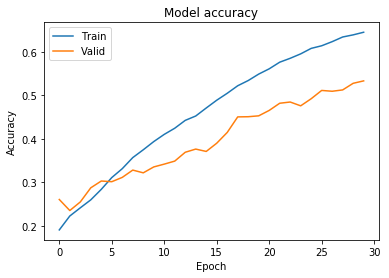

In [41]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('2019_03_07_accuracy.png')
plt.show()



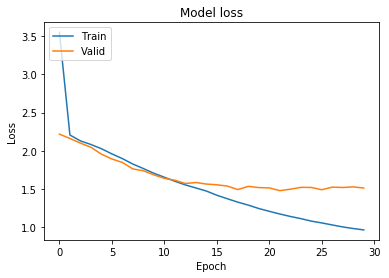

In [42]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('2019_03_07_loss.png')
plt.show()

In [43]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/ubuntu/NSynth/saved_models/keras_nsynth_trained_2019_03_07.h5 


In [44]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

4096/4096 [==============================] - 30s 7ms/step
Test loss: 1.4932936248369515
Test accuracy: 0.544921875
